In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
from google.colab import files

In [3]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['IMDB Dataset.csv']))

Saving IMDB Dataset.csv to IMDB Dataset (1).csv


*Preprocesssing the dataset.*



---


First tokenizing the reviews and creating its object tokenizer. Then fitting the tokenizer object and converting the reviews in dataset to a matrix. 

The words in dataset are assigned numbers, in this dataset there are a total of **154,337** words. Starting from the most common words first. 


Replacing the sentiment value in the dataset by numbers ranging from 
(0, no. of classes-1). 

In [52]:
df.describe()

tokenizer = keras.preprocessing.text.Tokenizer(num_words=100, lower=False)

tokenizer.fit_on_texts(df['review'])

sequences = tokenizer.texts_to_matrix(df['review'], mode='count')
idx_word = tokenizer.word_index

df = df.replace(pd.unique(df['sentiment']), [0,1])
Y = df['sentiment']

print('Indexed words: ', idx_word)
print('No.of indexed words: ', len(idx_word))
print('Modified dataset:\n',  map(sequences, Y))

Output hidden; open in https://colab.research.google.com to view.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import *

'''
    Dividing the dataset into training and validation data and shuffling them.
'''
X_train, X_val, y_train, y_val = train_test_split(sequences, Y, test_size=0.32, shuffle=True)
print("Training data shape --", X_train.shape)
print("Validation data shape --", X_val.shape)

Training data shape -- (34000, 30)
Validation data shape -- (16000, 30)


In [6]:
lr_clf = lr(random_state=42, verbose=1).fit(X=X_train, y=y_train)

clf_pred = lr_clf.predict(X_val)

conf_matrix = confusion_matrix(y_val, clf_pred)
print(conf_matrix)
print(classification_report(y_val, clf_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[5037 2990]
 [3004 4969]]
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      8027
           1       0.62      0.62      0.62      7973

    accuracy                           0.63     16000
   macro avg       0.63      0.63      0.63     16000
weighted avg       0.63      0.63      0.63     16000



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [11]:
model = keras.Sequential([
                          keras.Input(shape=(None,)),

                          keras.layers.Embedding(20000, 128),

                          keras.layers.Conv1D(128, 16, activation='relu', strides=3),
                          keras.layers.GlobalMaxPooling1D(),
                          keras.layers.Dropout(0.4),

                          keras.layers.Dense(128, activation='tanh'),
                          keras.layers.Dense(64, activation='relu'),

                          keras.layers.Dropout(0.45),
                          keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])

This above neural net, after running 100 epochs gives training_accuracy of around **86%**  but the validation accuracy starts from **55%** and with the final validation_accuracy not more than **60%.**

So as you can see the model performs well on the trainin_set after 100 epochs but the validation_accuracy remains stagnant in the range of 55 to 60%.

In [ ]:
model.fit(X_train, y_train, 
          epochs=100, verbose=1, 
          validation_data=(X_val, y_val))

In [7]:
lstm_model = keras.Sequential([
                               keras.Input(shape=(None,)),

                               keras.layers.Embedding(20000, 128),

                               keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
                               keras.layers.Bidirectional(keras.layers.LSTM(64)),

                               keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])

The above lstm network, after running 40 epochs gives training_accuracy of around **94.4%**  but the problem with validation dataset prevails like before.


In [8]:
hist = lstm_model.fit(X_train, y_train, 
          epochs=40, verbose=1, 
          validation_data=(X_val, y_val))

Epoch 1/40
1063/1063 [==============================] - 62s 48ms/step - loss: 0.6872 - accuracy: 0.5463 - mse: 0.2470 - val_loss: 0.6807 - val_accuracy: 0.5596 - val_mse: 0.2439
Epoch 2/40
1063/1063 [==============================] - 49s 46ms/step - loss: 0.6794 - accuracy: 0.5660 - mse: 0.2432 - val_loss: 0.6766 - val_accuracy: 0.5758 - val_mse: 0.2419
Epoch 3/40
1063/1063 [==============================] - 48s 45ms/step - loss: 0.6765 - accuracy: 0.5684 - mse: 0.2418 - val_loss: 0.6752 - val_accuracy: 0.5782 - val_mse: 0.2412
Epoch 4/40
1063/1063 [==============================] - 48s 45ms/step - loss: 0.6696 - accuracy: 0.5861 - mse: 0.2385 - val_loss: 0.6681 - val_accuracy: 0.5914 - val_mse: 0.2377
Epoch 5/40
1063/1063 [==============================] - 48s 45ms/step - loss: 0.6636 - accuracy: 0.5937 - mse: 0.2357 - val_loss: 0.6687 - val_accuracy: 0.5854 - val_mse: 0.2381
Epoch 6/40
1063/1063 [==============================] - 49s 46ms/step - loss: 0.6580 - accuracy: 0.6051 - mse:

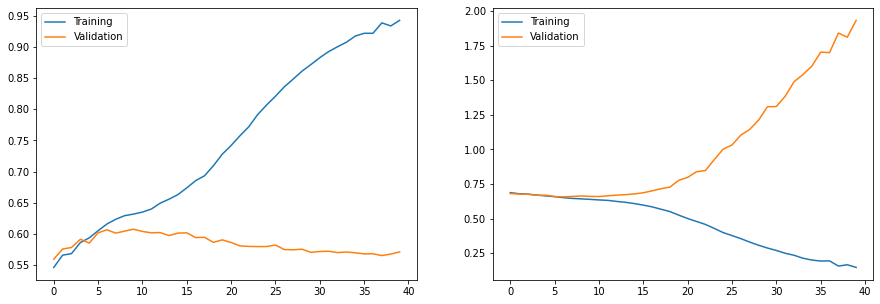

In [42]:
axes = [ax1,ax2]
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))

axes[0].plot(hist.history['accuracy'])
axes[0].plot(hist.history['val_accuracy'])
axes[0].legend(['Training', 'Validation'])

axes[1].plot(hist.history['loss'])
axes[1].plot(hist.history['val_loss'])
axes[1].legend(['Training', 'Validation'])

In [49]:
lstm_pred = lstm_model.predict(X_val)
final_pred = []
for l_pred in lstm_pred:
  if l_pred<0.5:
    final_pred.append(0)
  else:
    final_pred.append(1)
len(final_pred)

16000

In [53]:
print(classification_report(y_val, final_pred))
print(confusion_matrix(y_val, final_pred))

              precision    recall  f1-score   support

           0       0.58      0.55      0.56      8027
           1       0.57      0.59      0.58      7973

    accuracy                           0.57     16000
   macro avg       0.57      0.57      0.57     16000
weighted avg       0.57      0.57      0.57     16000

[[4401 3626]
 [3235 4738]]
